# 1D Beam thickness estimation

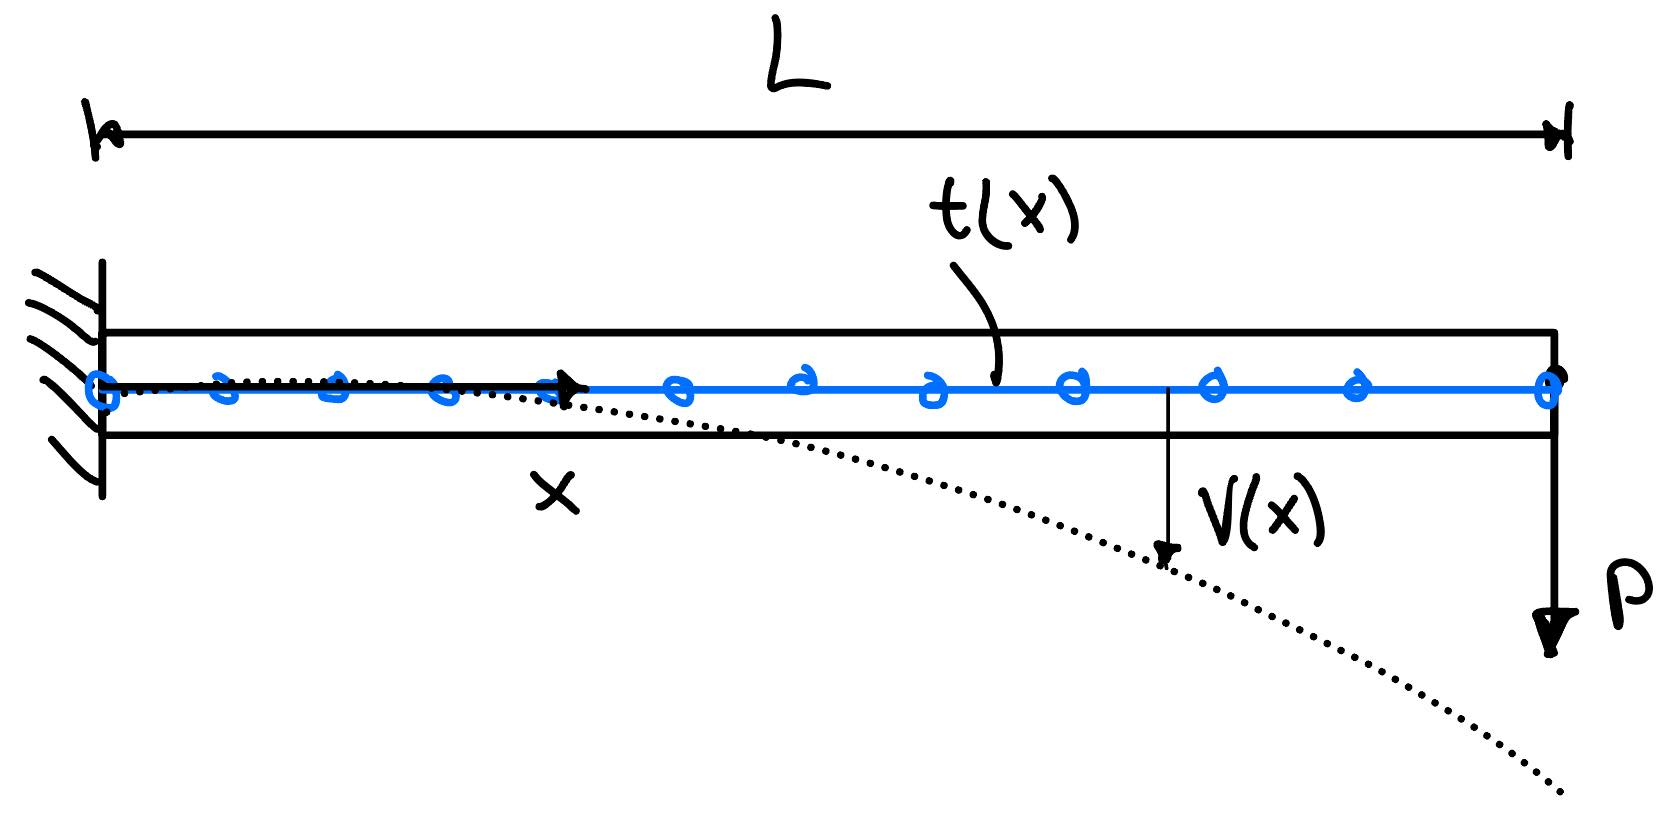

The Bayesian inverse problem is to infer the beam thicknesses, $\mathbf{t}$, along the beam from measurements of the beam deflections, $\mathbf{u}$. This can be formulated as

$$ \mathbf{v} = G(\mathbf{t}) + \epsilon $$

where the forward model found by solving the finite element equations:

$$ G(\mathbf{t}) = \mathbf{K}(\mathbf{t})^{-1} \mathbf{f} $$

To represent the thickness as a continuous random function, the KL expansion is introduced as:

$$ \mathbf{t} = \mu_t + \sigma \sum_{i=1}^{N_{KL}} Z_i \sqrt{\lambda_i} \mathbf{e}_i $$

This transforms the Bayesian inverse problem to instead being a problem of inferring the coefficients, $Z_i$, i.e.

$$ \mathbf{v} = G(\mathbf{t}(Z_i)) + \epsilon $$


The noise is assummed Gaussian

$$ \epsilon \sim \mathcal{N}(0, \sigma_{obs}^2 ) $$

The likelihood function is obtained from the forward model as

### Analytical model:

The relation between the beam deflection, $u$, and the external forces is given by the Euler-Bernoulli beam equation:

$$ M(x) = -EI(x) \frac{d^2 v(x)}{d x^2}  $$

The bending stiffness of the beam is a product of the Young's modulus of the material, $E$, and the second moment of area, $I$. The second moment of area of a rectangular beam is related to the beam thickness by

$$ I = \frac{1}{12}bt^3 $$

The moment distribution for the tip load is found as 

$$ M(x) = -P(L - x) $$

Thus, the beam deflection can be found by solving the beam equation:

$$\frac{d^2 v(x)}{d x^2} =  \frac{P}{EI(x)}(L - x) $$
